In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision.models.video import swin_transformer

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
dirpath = 'Cardiac-Video-Sequence/' # Change to location of this folder on your device
X = torch.load(dirpath+'X_tensor.pt')
Y = torch.load(dirpath+'Y_tensor.pt')

In [4]:
X.shape, Y.shape

(torch.Size([112, 25, 80, 80]), torch.Size([112, 126]))

In [5]:
class TOCDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: torch.Tensor of shape (N, 25, 80, 80) - videos
        Y: torch.Tensor of shape (N, 126) - target curves
        """
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Expand to 3 channels by repeating along the channel dimension
        video = self.X[idx].unsqueeze(0).repeat(3, 1, 1, 1)  # Shape: (3, 25, 80, 80)
        curve = self.Y[idx]
        return video, curve

In [6]:
# Initialize the model
model = swin_transformer.swin3d_b(weights=None)  # Use SwinTransformer3D Tiny variant

# Modify the classification head to match the output shape (126 points)
model.head = torch.nn.Linear(model.head.in_features, 126)

In [7]:
# Create dataset and data loader
dataset = TOCDataset(X, Y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
bs = 8

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [8]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Use MSELoss for regression
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)  # Xavier initialization for weights
            if m.bias is not None:
                init.zeros_(m.bias)

In [10]:
init_weights(model)

In [11]:
# Training loop
# Early stopping setup
patience = 5
best_train_loss = float('inf')
patience_counter = 0
best_model_weights = None

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, curves in train_loader:
        videos, curves = videos.to(device), curves.to(device)

        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, curves)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    # Early stopping logic
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        patience_counter = 0
        best_model_weights = model.state_dict()  # Save the best model weights
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Validation loss did not improve for {patience} epochs.")
            break

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs} loss: {avg_train_loss: .4f}")
        
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Restored the best model weights.")
    

Epoch 0/500 loss:  947.4537
Epoch 5/500 loss:  244.8209
Epoch 10/500 loss:  223.0412
Early stopping triggered. Validation loss did not improve for 5 epochs.
Restored the best model weights.


In [18]:
torch.save(model.state_dict(), dirpath+'swin3d_weights.pth')

In [12]:
# Function to plot predictions vs. ground truths
def plot_predictions(predictions, ground_truths, num_samples=5):
    num_samples = min(num_samples, len(predictions))
    indices = torch.randint(0, len(predictions), (num_samples,))  # Randomly select samples

    for i, idx in enumerate(indices):
        plt.figure(figsize=(6, 3))
        plt.plot(ground_truths[idx].numpy(), label="True Curve", linestyle='--')
        plt.plot(predictions[idx].numpy(), label="Predicted Curve", linestyle='-')
        plt.title(f"Sample {i + 1}")
        plt.xlabel("Point Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

In [13]:
# Function to evaluate the model on the test set and compute both MSE and R²
def evaluate_model_r2(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for videos, curves in test_loader:
            videos, curves = videos.to(device), curves.to(device)
            
            # Forward pass
            outputs = model(videos)
            
            # Accumulate predictions and ground truth for plotting
            predictions.append(outputs.cpu())
            ground_truths.append(curves.cpu())
            
            # Compute MSE for the batch
            total_mse += nn.MSELoss()(outputs, curves).item()

    # Concatenate predictions and ground truths for plotting
    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)

    # Compute average MSE
    avg_mse = total_mse / len(test_loader)

    # Compute R² score
    r2 = r2_score(ground_truths.numpy(), predictions.numpy())

    return avg_mse, r2, predictions, ground_truths

Test MSE: 240.7196
Test R²: -4.1291


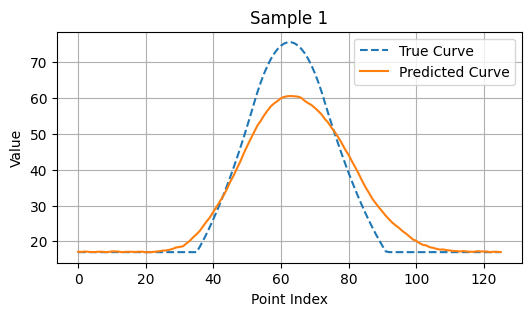

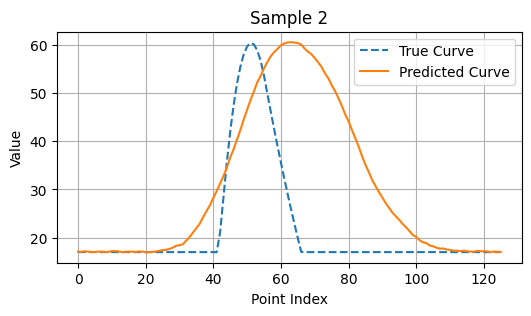

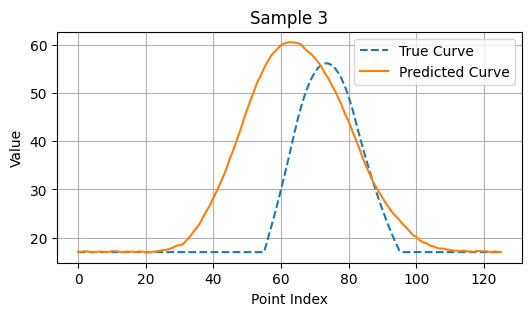

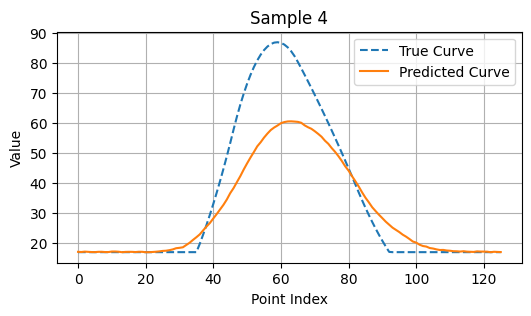

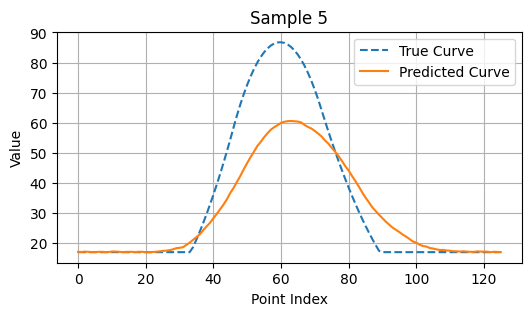

In [16]:
# Example usage
test_mse, r2, predictions, ground_truths = evaluate_model_r2(model, test_loader, device)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {r2:.4f}")

# Optionally, plot the predicted vs true curves
plot_predictions(predictions, ground_truths)